# Test:

Just go right to 1c. The corrections are currently fast enough to where a downgrade to 512 is not necessary, especially when actual corrections will still occur at the 4096 level. Run the 1c test with a couple different cuts, then move on to test 2 (get some ideas for relative distributions using stellar stream pipeline). Then, make a new folder which will house the final product, do a bit of work, and then be done.

# To Do:

The only information that's useful is when a non complete train run is done, with something like 80%. Redo this after a certain point to keep that in mind.

In [1]:
import fitsio
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib
from scipy import interpolate as inter
from astropy.table import Table
import BalrogTestConfig as balrConfig
import Config
from TrainAndFullMap import *
from timeit import default_timer as timer
import StellarConfig as strConfig
from matplotlib.path import Path

In [2]:
cutOffPercent = .01
res = 4096
# lowRes = 512
binNum = 10

In [3]:
# allPixFile = balrConfig.test1AllPixFile # This is actually unneeded at this point
validPixFile = balrConfig.test1ValidPixFile

matBalrStarFile = balrConfig.matBalrStarFile

In [4]:
# injPix = hp.ang2pix(4096, fitsio.read(allPixFile)['RA'], fitsio.read(allPixFile)['DEC'], nest = True, lonlat = True)
validPix = fitsio.read(validPixFile)['PIXEL']

## Applying Cuts:

This is where some sort of cut is applied. Maybe start with a general color, magnitude, and class cut (has to be a classified star lets say). Later on, with some added complexity from another file, we should test adding in quality cuts on flags from the detBalrStarFile.

In [5]:
classCut = 1.5
path = strConfig.path
mu = strConfig.mu

In [6]:
starData = fitsio.read(matBalrStarFile, columns = ['meas_ra', 'meas_dec', 'meas_EXTENDED_CLASS_SOF', 'meas_psf_mag'])

In [7]:
matRa = starData['meas_ra']
matDec = starData['meas_dec']
matRmag = starData['meas_psf_mag'][:,1]
matGmag = starData['meas_psf_mag'][:,0]
matClass = starData['meas_EXTENDED_CLASS_SOF']

In [8]:
matPix = hp.ang2pix(res, matRa, matDec, nest = True, lonlat = True)

In [9]:
# If this is non one, some matched pixels aren't in the valid pix, which is to be expected.
# This is the first cut to perform.
np.average(np.isin(matPix, validPix))

0.9877826288174058

In [10]:
pixCut = np.isin(matPix, validPix)
matPix = matPix[pixCut]
matRmag = matRmag[pixCut]
matGmag = matGmag[pixCut]
matClass = matClass[pixCut]

In [11]:
magCut = np.where(matRmag <= 25)[0]

matPix = matPix[magCut]
matRmag = matRmag[magCut]
matGmag = matGmag[magCut]
matClass = matClass[magCut]

In [12]:
MG = matGmag - mu
GR = matGmag - matRmag

filterSelection=Path.contains_points(path,np.vstack((GR,MG)).T)

matClass = matClass[filterSelection]
matPix = matPix[filterSelection]

In [13]:
classCuts = np.where((matClass >= 0) &
                     (matClass <= classCut))[0]

In [14]:
matPix = matPix[classCuts]

In [15]:
# This is the percent of matched stars left for the procedure
len(matPix) / len(matRa)

0.15666683394389522

In [16]:
_, origDetPixCounts = np.unique(np.append(validPix, matPix), return_counts = True)
origDetPixCounts = origDetPixCounts - 1

In [17]:
condFiles = balrConfig.test1CondFiles

pcMaps = []

# This loops over every condition file
for condFile in condFiles:
    condData = fitsio.read(condFile) # This reads in the data
    pcMaps.append(condData['SIGNAL']) # Only stores the values that are in pixels with injections

pcMaps = np.array(pcMaps)

In [18]:
aveDet = np.sum(origDetPixCounts) / len(origDetPixCounts)

In [19]:
trainInds = np.full(len(pcMaps[0]), False, dtype = bool)
trainInds[0:int(0.8*len(trainInds))] = True
np.random.shuffle(trainInds)

sortInds = []
for i in range(len(pcMaps)):
    sortInds.append(pcMaps[i][trainInds].argsort())
sortInds = np.array(sortInds)

In [20]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [21]:
xBins = []

for i in range(len(pcMaps)):
    PC_Map_Sort = pcMaps[i][trainInds][sortInds[i][::1]]
    pcBins = []
    for j in range(binNum):
        pcBins.append(PC_Map_Sort[binIndLims[j]:binIndLims[j+1]])
    indXBin = []

    for j in range(binNum):
        indXBin.append(np.sum(pcBins[j]) / len(pcBins[j]))
        
    xBins.append(np.array(indXBin))

xBins = np.array(xBins)

In [22]:
yBinsOrig = []
for i in range(len(pcMaps)):
    detSort = origDetPixCounts[trainInds][sortInds[i][::1]]
    detBins = []
    for j in range(binNum):
        detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
    indYBinOrig = []

    for j in range(binNum):
        indYBinOrig.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

    yBinsOrig.append(np.array(indYBinOrig))

yBinsOrig = np.array(yBinsOrig)

In [23]:
def mostSigInd(y):
    maxSquaredDiff = 0
    index = -1
    
    maxSingError = np.max(np.abs(y - 1))
    
    if maxSingError <= cutOffPercent:
        return index, maxSingError
    
    for i in range(len(y)):
        yi = y[i]
        
        diff = np.sum((yi - 1)**2)
        
        if diff > maxSquaredDiff:
            maxSquaredDiff = diff
            index = i
            
    return index, maxSingError

In [24]:
detPixCounts = np.copy(origDetPixCounts)

In [25]:
timeThrough = 0
allErrors = []

start = timer()

while(True):
    
    timeThrough += 1
    if timeThrough % 20 == 0:
        print(timeThrough)
    
    yBins = []
    for i in range(len(pcMaps)):
        detSort = detPixCounts[trainInds][sortInds[i][::1]]
        detBins = []
        for j in range(binNum):
            detBins.append(detSort[binIndLims[j]:binIndLims[j+1]])
        indYBin = []

        for j in range(binNum):
            indYBin.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))

        yBins.append(np.array(indYBin))

    yBins = np.array(yBins)
    
    index, maxErr = mostSigInd(yBins)
    if index == -1:
        break
        
    allErrors.append(maxErr)
        
    corrFunc = inter.interp1d(xBins[index], yBins[index], bounds_error = False, fill_value = (yBins[index][0], yBins[index][-1]))
    
    detPixCounts = detPixCounts / (corrFunc(pcMaps[index]))
    
    detPixCounts = detPixCounts * aveDet / (np.sum(detPixCounts) / len(detPixCounts))
    
    if timeThrough == 1:
        end = timer()
        print(str(end - start) + ' seconds per loop') # time in seconds

4.201010743621737 seconds per loop
20
40
60
80
100


In [26]:
# errorsFile = balrConfig.test1cDir + 'Errors_' + str(cutOffPercent) + '.fits'
# detPixFile = balrConfig.test1cDir + 'Pix_Counts_' + str(cutOffPercent) + '.fits'
# trainIndsFile = balrConfig.test1cDir + 'Train_Inds_' + str(cutOffPercent) + '.fits'

In [27]:
# my_table = Table()
# my_table['Errors'] = allErrors
# my_table.write(errorsFile, overwrite = True)

In [28]:
# my_table = Table()
# my_table['Counts'] = detPixCounts
# my_table.write(detPixFile, overwrite = True)

In [29]:
# my_table = Table()
# my_table['Inds'] = trainInds
# my_table.write(trainIndsFile, overwrite = True)

In [30]:
# allErrors = fitsio.read(errorsFile)['Errors']
# detPixCounts = fitsio.read(detPixFile)['Counts']
# trainInds = fitsio.read(trainIndsFile)['Inds']

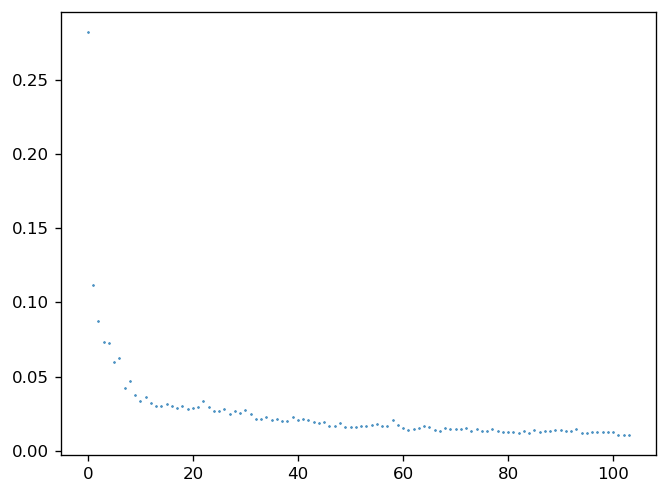

In [31]:
plt.figure(dpi = 120)
plt.scatter(np.arange(len(allErrors)), allErrors, s = 0.25)
plt.show()

In [32]:
condFiles = balrConfig.test1CondFiles
conditions = Config.conditions

In [33]:
condMaps = np.copy(pcMaps)

In [34]:
binIndLims = [0]

for j in range(binNum):
    binIndLims.append(int((np.sum(~trainInds) - binIndLims[-1]) / (binNum - j)) + (binIndLims[-1]))

In [35]:
condMaxErrors = []
condMaxErrorsOrig = []

for condInd in range(len(condMaps)):
    condMap = condMaps[condInd]
    condSortInds = condMap[~trainInds].argsort()
    
    condSort = condMap[~trainInds][condSortInds[::1]]
    detStarTemp = detPixCounts[~trainInds][condSortInds[::1]]
    origDetStarTemp = origDetPixCounts[~trainInds][condSortInds[::1]]

    origDetBins = []
    detBins = []
    condBins = []

    for j in range(10):
        origDetBins.append(origDetStarTemp[binIndLims[j]:binIndLims[j+1]])
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        condBins.append(condSort[binIndLims[j]:binIndLims[j+1]])

    yBinCondOrig = []
    yBinCond = []
    xBinCond = []

    for j in range(10):
        yBinCondOrig.append(np.sum(origDetBins[j]) / (aveDet * len(origDetBins[j])))
        yBinCond.append(np.sum(detBins[j]) / (aveDet * len(detBins[j])))
        xBinCond.append(np.sum(condBins[j]) / len(condBins[j]))

    xBinCond = np.array(xBinCond)
    yBinCond = np.array(yBinCond)
    yBinCondOrig = np.array(yBinCondOrig)
    
    condMaxErrorsOrig.append(np.max(np.abs(yBinCondOrig - 1)))
    condMaxErrors.append(np.max(np.abs(yBinCond - 1)))
    
    # plt.figure(dpi = 120)
    # plt.plot(xBinCond, yBinCond, marker = 'o', label = r'Corrected Dependency, ' + r'$\sigma = $' + str(np.round(np.std(yBinCond), decimals = 3)), zorder = 4)
    # plt.plot(xBinCond, yBinCondOrig, marker = 'o', label = r'Original Dependency, ' + r'$\sigma = $' + str(np.round(np.std(yBinCondOrig), decimals = 3)), zorder = 4)
    # plt.axhline(y = 1, color = 'black', linestyle = '--', zorder = 3)
    # plt.legend()
    # plt.title('Stellar Detection Rate Dependencies')
    # plt.grid(zorder = 0)
    # plt.xlabel(conditions[condInd])
    # plt.ylabel(r'$N/\langle N\rangle$')
    # plt.savefig('80PerTrain1c/' + conditions[condInd])

In [36]:
np.average(condMaxErrors)

0.02507034452330897

In [37]:
np.average(np.array(condMaxErrors) / np.array(condMaxErrorsOrig))

0.3008979773860907

In [38]:
np.sum(condMaxErrors) / np.sum(condMaxErrorsOrig)

0.21645594490030445

## Issue (From Earlier):

This shows an issue not yet considered, what happens if the balrog injection is in a valid 512 pixel, but not in a valid 4096 pixel? An easy potential fix would be just only considering 512 pixels which have complete 4096 coverage. I'll take a look at what the full footprint looks like when that is done. Another potential fix would be have ones in an invalid 4096 pixel get "fill in" values, but this might lead to some issues (leave this for someone else if it looks like it'll be fine).

In [39]:
# import StellarConfig as strConfig

In [40]:
# origCondFiles = strConfig.origCondFiles
# stelFile = strConfig.stelFile

In [41]:
# # This will be used to check where valid pixels are.
# validPix = np.full(12*(4096**2), True, dtype = bool)

# for file in origCondFiles:
#     condData = fitsio.read(file) # This reads in the data.
#     condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value.
#     condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals.
#     validPix[np.where(condSigExt < -100)] = False # An invalid survey property marks this pixel as false.

# stelDensExt = fitsio.read(stelFile)['I'].flatten() # Loads in the stellar density.
# validPix[np.where(stelDensExt < -100)] = False # Any non valid pixel has its value changed to False.

# # This reduces the healpixel resolution to the requested size.
# validPixRes = np.full(12*(4096**2), 0.0)
# validPixRes[validPix] = 1.0
# validPixRes = hp.ud_grade(validPixRes, 512, order_in = 'NESTED', order_out = 'NESTED')

# # This provides a cutoff for what percent of the superpixel has to be covered to be considered valid.
# PIX = np.where(validPixRes >= 0.999)[0]

In [42]:
# fullPix = np.full(12*(512**2), hp.UNSEEN)
# fullPix[PIX] = 0

In [43]:
# import healsparse as hsp
# import skyproj

In [44]:
# nside_coverage = 32
# hspPix = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullPix)

In [45]:
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(hspPix, cmap = 'bwr')
# plt.clim(0, 1)
# # plt.colorbar(location = 'bottom', label = '512 Pixels with Full 4096 Coverage')
# fig.suptitle(r'512 Pixels with Full 4096 Coverage')
# plt.show()